ORES HDFS Data Inspection
===

See https://phabricator.wikimedia.org/T277609


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import json
from datetime import datetime
import dateutil
import pytz
from tqdm import tqdm

In [3]:
ores_preds_2019_filepath = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/raw/editquality/hdfs/ores_scores_damaging-goodfaith_enwiki_2019_01-12.json"
TRUSTED_GROUPS = ['sysops','oversight','bot','rollbacker','checkuser','abusefilter','bureaucrat']

In [4]:
iso_string = "2019-12-31T23:59:59Z"
dt = dateutil.parser.isoparse(iso_string)
dt, dt.timestamp(), int(datetime.strptime(iso_string, "%Y-%m-%dT%H:%M:%SZ").timestamp())

(datetime.datetime(2019, 12, 31, 23, 59, 59, tzinfo=tzutc()),
 1577836799.0,
 1577858399)

In [5]:
missing_registration_date_count = 0
with open(ores_preds_2019_filepath, 'r') as infile:
    lines = []
    for line in tqdm(infile, total=54683129):
        op = json.loads(line)
        rev_id = op['rev_id']
        pred_timestamp = dateutil.parser.isoparse(op['pred_dt']).timestamp()

        user = op['performer']
        user_text = user['user_text']
        user_is_bot = user['user_is_bot']
        user_id = user['user_id'] if 'user_id' in user else None
        user_groups = set(user['user_groups'])
        if user_id:
            user_is_trusted = np.any([group in TRUSTED_GROUPS for group in user_groups])
            user_edit_count = user['user_edit_count']
            if 'user_registration_dt' not in user:
                missing_registration_date_count += 1
            #else:
                #user_registration_timestamp = dateutil.parser.isoparse(user['user_registration_dt']).timestamp()
        else:
            user_is_trusted = False
            user_edit_count = 0


        dinfo = op['damaging_info']
        model_version = dinfo['model_version']
        damaging_pred = dinfo['probability']['true']

        gfinfo = op['goodfaith_info']
        #assert gfinfo['model_version'] == model_version
        goodfaith_pred = gfinfo['probability']['true']

        lines.append({
            'rev_id': rev_id,
            'pred_timestamp': pred_timestamp,
            'user_text': user_text,
            'user_is_bot': user_is_bot,
            'user_is_trusted': user_is_trusted,
            'user_edit_count': user_edit_count,
            'model_version': model_version,
            'damaging_pred': damaging_pred,
            'goodfaith_pred': goodfaith_pred,
        })
missing_registration_date_count

100%|██████████| 54683129/54683129 [1:07:03<00:00, 13590.48it/s]


183887

In [6]:
s = datetime.now()
df = pd.DataFrame(lines)
len(df), datetime.now() - s

(54683129, datetime.timedelta(seconds=162, microseconds=70796))

In [7]:
df.head()

,rev_id,pred_timestamp,user_text,user_is_bot,user_is_trusted,user_edit_count,model_version,damaging_pred,goodfaith_pred
0,876227280,1.546301e+09,InternetArchiveBot,True,True,3109800,0.4.0,0.005061,0.996423
1,876227282,1.546301e+09,DynamoDegsy,False,False,158278,0.4.0,0.011485,0.991927
2,876227283,1.546301e+09,TerribleTy2727,False,False,46,0.4.0,0.221970,0.935729
3,876227281,1.546301e+09,175.36.4.199,False,False,0,0.4.0,0.265990,0.944493
4,876227286,1.546301e+09,InceptionBot,True,True,1156474,0.4.0,0.005774,0.996814


In [8]:
df.model_version.value_counts()

0.5.0    53626234
0.4.0     1056895
Name: model_version, dtype: int64

In [9]:
oidb_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/oidb"
s = datetime.now()
df.to_feather(os.path.join(oidb_dir, 'ores_2019.feather'))
print(f"Finished saving to feather in {datetime.now() - s}.")

Finished saving to feather in 0:00:21.492500.


In [10]:
# free up some memory
del lines

In [5]:
# read in the ores predictions
oidb_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/oidb"
s = datetime.now()
ores_df = pd.read_feather(os.path.join(oidb_dir, 'ores_2019.feather'))
print(f"Loaded {len(ores_df)} rows from feather in {datetime.now() - s}.")
ores_df.head()

Loaded 54683129 rows from feather in 0:00:10.147248.


,rev_id,pred_timestamp,user_text,user_is_bot,user_is_trusted,user_edit_count,model_version,damaging_pred,goodfaith_pred
0,876227280,1.546301e+09,InternetArchiveBot,True,True,3109800,0.4.0,0.005061,0.996423
1,876227282,1.546301e+09,DynamoDegsy,False,False,158278,0.4.0,0.011485,0.991927
2,876227283,1.546301e+09,TerribleTy2727,False,False,46,0.4.0,0.221970,0.935729
3,876227281,1.546301e+09,175.36.4.199,False,False,0,0.4.0,0.265990,0.944493
4,876227286,1.546301e+09,InceptionBot,True,True,1156474,0.4.0,0.005774,0.996814


In [6]:
ores_df.sample(n=10)

,rev_id,pred_timestamp,user_text,user_is_bot,user_is_trusted,user_edit_count,model_version,damaging_pred,goodfaith_pred
24408525,901148879,1.560127e+09,Everedux,False,True,16013,0.5.0,0.028979,0.993628
6831422,883177355,1.550086e+09,Abdotorg,False,True,15842,0.5.0,0.008631,0.991590
38166024,916021145,1.568647e+09,Bluesangrel,False,False,120669,0.5.0,0.032846,0.975894
29427568,906267830,1.563134e+09,The Man in Question,False,False,39237,0.5.0,0.003961,0.997817
53918793,932663265,1.577452e+09,Kleool,False,False,1394,0.5.0,0.014921,0.994792
15054827,891578377,1.554758e+09,Imtiyaz3333,False,False,45,0.5.0,0.021867,0.990273
17119149,893688996,1.555977e+09,Legende Legende,False,False,371,0.5.0,0.390158,0.793651
3134588,879415019,1.548039e+09,Riccckyyy,False,False,5057,0.5.0,0.022409,0.992371
16695846,893250736,1.555728e+09,JJMC89,False,True,180252,0.5.0,0.006380,0.993517
14439460,890950077,1.554396e+09,Xqbot,True,True,1690108,0.5.0,0.008237,0.994945


In [7]:
s = datetime.now()
ores_df = ores_df.sort_values(by='pred_timestamp', ascending=True)
print(f"Finished sort in {datetime.now() - s}.")

Finished sort in 0:00:10.325627.


In [8]:
# 1277 duplicate rev_ids
s = datetime.now()
rev_counts = ores_df.rev_id.value_counts()
print(f"Identified {len(rev_counts)} unique rev_ids of which {np.sum(rev_counts > 1)} are duplicated at least once. Done in {datetime.now() - s}.")
rev_counts[rev_counts > 1].head(20)

Identified 54681789 unique rev_ids of which 1277 are duplicated at least once. Done in 0:00:22.592790.


899529828    5
920236003    4
920235961    4
920235996    4
895233079    3
920236002    3
897298148    3
924403009    3
920236006    3
920235990    3
931428681    3
899514155    3
914334321    3
916183612    3
914334401    3
924403016    3
896140848    3
920235992    3
900656693    3
919177360    3
Name: rev_id, dtype: int64

In [9]:
# drop duplicate rev_ids
s = datetime.now()
ores_df = ores_df.drop_duplicates(subset='rev_id', keep='first')
len(ores_df), str(datetime.now() - s)

(54681789, '0:00:36.144979')

In [10]:
# make rev_id the index
ores_df = ores_df.set_index('rev_id')

In [17]:
# generate the user_text_dict
# needed in order to 
user_text_dict = {}
on_newcomer_crux_count = 0
on_max_edit_crux_count = 0
for user_text, group in tqdm(ores_df.groupby(by='user_text', sort=False)):
    user_is_bot = np.any(group.user_is_bot)
    user_is_trusted = np.any(group.user_is_trusted)
    min_edits = np.min(group.user_edit_count)
    max_edits = np.min(group.user_edit_count)
    if min_edits < 10 and max_edits > 10:
        #print(f"User on the 10-edit crux; {user_text}")
        #print(group)
        #break
        on_newcomer_crux_count += 1
    elif min_edits < 500 and max_edits > 500:
        #print(f"User on the 500-edit crux; {user_text}")
        #print(group)
        #break
        on_max_edit_crux_count += 1
    user_edit_count = int(np.median(group.user_edit_count))
    user_text_dict[user_text] = (user_is_bot, user_is_trusted, user_edit_count)
on_newcomer_crux_count, on_max_edit_crux_count

100%|██████████| 3874852/3874852 [44:35<00:00, 1448.19it/s]


(0, 0)

In [11]:
oidb_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/oidb"
missing_ores_df = pd.read_csv(os.path.join(oidb_dir, 'rev_ids_missing_scores_available.csv'), 
                             header=None,
                             names=['rev_id', 'damaging_pred', 'damaging_label', 'd_model_version', 'goodfaith_pred', 'goodfaith_label', 'gf_model_version']
                             )
len(missing_ores_df)

2277346

In [12]:
missing_ores_df.head()

,rev_id,damaging_pred,damaging_label,d_model_version,goodfaith_pred,goodfaith_label,gf_model_version
0,880647041,0.008813,False,0.5.1,0.989774,True,0.5.1
1,879351281,0.006221,False,0.5.1,0.996597,True,0.5.1
2,883544619,0.003113,False,0.5.1,0.998540,True,0.5.1
3,880306481,0.021600,False,0.5.1,0.980105,True,0.5.1
4,884600289,0.008411,False,0.5.1,0.992072,True,0.5.1


In [13]:
# make rev_id the index
missing_ores_df = missing_ores_df.set_index('rev_id')

In [15]:
page_info_dict = {}
with open(os.path.join(oidb_dir, 'page.ndjson'), 'r') as infile:
    for line in tqdm(infile, total=15570615):
        page = json.loads(line)
        page_id = page['page_id']
        page_info = page['range_rev_count'], page['wiki_namespace'], page['is_page_redirect']
        page_info_dict[page_id] = page_info

100%|██████████| 15570615/15570615 [02:08<00:00, 120903.43it/s]


In [18]:
start_date = datetime.fromisoformat('2019-01-01').replace(tzinfo=pytz.UTC)  # start of 2019
start_timestamp = int(start_date.timestamp())
midpoint_date = datetime.fromisoformat('2020-01-01').replace(tzinfo=pytz.UTC)
midpoint_timestamp = int(midpoint_date.timestamp())
end_date = datetime.fromisoformat('2021-01-01').replace(tzinfo=pytz.UTC)
end_timestamp = int(end_date.timestamp())
with open(os.path.join(oidb_dir, 'revs.tsv'), 'r') as infile, open(os.path.join(oidb_dir, 'revs_scored.tsv'), 'w') as outfile:
    processed_count = 0
    missing_rev_ids = set()
    missing_score_count = 0
    existing_user_available_count = 0
    for line in tqdm(infile, total=117569278, desc='Reading revision data'):
        processed_count += 1
        tokens = line.strip().split('\t')
        assert len(tokens) == 20
        rev_timestamp, page_id, rev_id, prev_rev_id, is_minor, user_text, user_id, seconds_to_prev, curr_bytes, delta_bytes, has_edit_summary, is_reverted, is_revert, is_reverted_to_by_other, is_self_reverted, is_self_revert, revert_target_id, revert_set_size, revert_id, seconds_to_revert = tokens
        rev_id = int(rev_id)
        page_id = int(page_id)
        rev_timestamp = int(rev_timestamp)
        if rev_timestamp > midpoint_timestamp:
            break
        # speed note: using .at is fast, much faster than .loc, still slower than dicts but fine
        if rev_id in ores_df.index:
            damaging_pred = ores_df.at[rev_id, 'damaging_pred']
            goodfaith_pred = ores_df.at[rev_id, 'goodfaith_pred']
            model_version = ores_df.at[rev_id, 'model_version']
            user_is_bot = ores_df.at[rev_id, 'user_is_bot']
            user_is_trusted = ores_df.at[rev_id, 'user_is_trusted']
            user_edit_count = ores_df.at[rev_id, 'user_edit_count']
        elif rev_id in missing_ores_df.index:
            missing_score_count += 1
            if missing_score_count == 1:
                print("Identified first available 'missing' score.")
            damaging_pred = missing_ores_df.at[rev_id, 'damaging_pred']
            goodfaith_pred = missing_ores_df.at[rev_id, 'goodfaith_pred']
            model_version = missing_ores_df.at[rev_id, 'd_model_version']
            
            #user_group = ores_df[ores_df.user_text == user_text]
            #if len(user_group) == 0:
            if user_text not in user_text_dict:
                user_is_bot = False
                user_is_trusted = False
                user_edit_count = 0
            else:
                existing_user_available_count += 1
                if existing_user_available_count == 1:
                    print(f"Identified first 'missing' rev with available user info. {rev_id} {user_text}")
                user_is_bot, user_is_trusted, user_edit_count = user_text_dict[user_text]
                #user_is_bot = np.any(user_group.user_is_bot)
                #user_is_trusted = np.any(user_group.user_is_trusted)
                #user_edit_count = int(np.median(user_group.user_edit_count))
        else:
            # rev id just plain missing
            missing_rev_ids.add(rev_id)
            if len(missing_rev_ids) == 1:
                print(f"Identified first completely missing score. {rev_id}")
            continue
        # get page data
        page_info = page_info_dict[page_id]
        page_rev_count, page_namespace, is_page_redirect = page_info
            
        new_line = line.strip() + f"\t{damaging_pred}\t{goodfaith_pred}\t{model_version}\t{user_is_bot}\t{user_is_trusted}\t{user_edit_count}\t{page_rev_count}\t{page_namespace}\t{is_page_redirect}\n"
        outfile.write(new_line)
len(missing_rev_ids), processed_count, len(missing_rev_ids) / processed_count

Reading revision data:   0%|          | 2876/117569278 [00:00<2:15:31, 14458.79it/s]

Identified first completely missing score. 876227356
Identified first available 'missing' score.
Identified first 'missing' rev with available user info. 876227372 AnomieBOT


Reading revision data:  47%|████▋     | 55130432/117569278 [58:47<1:06:34, 15629.80it/s]


(59262, 55130433, 0.0010749416751361267)

In [21]:
missing_score_count, existing_user_available_count, existing_user_available_count / missing_score_count

(2277346, 2082589, 0.9144807157103049)

In [22]:
f"In {missing_score_count - existing_user_available_count} cases, we had no user info so we assumed the user was not a bot, not trusted, and had no edits."

'In 194757 cases, we had no user info so we assumed the user was not a bot, not trusted, and had no edits.'

In [20]:
list(missing_rev_ids)[:5]

[917635072, 898236417, 911736835, 916324356, 923533315]

### Earlier investigation of data quality

Includes code to identify rev_ids without ORES predictions.

In [8]:
rev_id_pred_timestamp_dict = {
    rev_id: pred_timestamp
    for rev_id, pred_timestamp in tqdm(zip(ores_df.rev_id, ores_df.pred_timestamp), total=len(ores_df))
}
len(rev_id_pred_timestamp_dict)

100%|██████████| 54683129/54683129 [00:29<00:00, 1877645.94it/s]


54681789

In [10]:
start_date = datetime.fromisoformat('2019-01-01').replace(tzinfo=pytz.UTC)  # start of 2019
start_timestamp = int(start_date.timestamp())
midpoint_date = datetime.fromisoformat('2020-01-01').replace(tzinfo=pytz.UTC)
midpoint_timestamp = int(midpoint_date.timestamp())
end_date = datetime.fromisoformat('2021-01-01').replace(tzinfo=pytz.UTC)
end_timestamp = int(end_date.timestamp())
with open(os.path.join(oidb_dir, 'revs.tsv'), 'r') as infile:
    processed_count = 0
    missing_rev_count = 0
    missing_in_2019_count = 0
    missing_rev_ids = set()
    pred_delay_list = []
    for line in tqdm(infile, total=117569278, desc='Reading revision data'):
        processed_count += 1
        tokens = line.strip().split('\t')
        assert len(tokens) == 20
        rev_timestamp, page_id, rev_id, prev_rev_id, is_minor, user_text, user_id, seconds_to_prev, curr_bytes, delta_bytes, has_edit_summary, is_reverted, is_revert, is_reverted_to_by_other, is_self_reverted, is_self_revert, revert_target_id, revert_set_size, revert_id, seconds_to_revert = tokens
        rev_id = int(rev_id)
        rev_timestamp = int(rev_timestamp)
        if rev_id not in rev_id_pred_timestamp_dict:
            missing_rev_count += 1
            if rev_timestamp >= start_timestamp and rev_timestamp <= midpoint_timestamp:
                missing_in_2019_count += 1
                missing_rev_ids.add(rev_id)
        else:
            pred_timestamp = rev_id_pred_timestamp_dict[rev_id]
            pred_delay_list.append(pred_timestamp - int(rev_timestamp))
missing_rev_count, processed_count

Reading revision data: 117579242it [07:15, 270151.42it/s]                               


(64785418, 117579242)

In [11]:
missing_rev_count / processed_count

0.5509936694437952

In [14]:
# 2% of the missing revisions are from 2019.
missing_in_2019_count, missing_in_2019_count / processed_count

(2336608, 0.019872623434670552)

In [17]:
# save the missing revisions
oidb_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/oidb"
missing_rev_id_list = sorted(list(missing_rev_ids))
with open(os.path.join(oidb_dir, 'rev_ids_missing_scores.txt'), 'w') as outfile:
    for rev_id in missing_rev_id_list:
        outfile.write(str(rev_id) + "\n")
print("Finished.")

Finished.


In [20]:
list(rev_id_pred_timestamp_dict)[-1]

933439940

In [25]:
pred_delay_list = np.array(pred_delay_list)
len(pred_delay_list)

52793834

In [33]:
pred_delay_list += 18000

In [34]:
np.min(pred_delay_list), \
np.quantile(pred_delay_list, 0.01), \
np.quantile(pred_delay_list, 0.5), \
np.quantile(pred_delay_list, 0.99),\
np.max(pred_delay_list)

(-3599.4960000514984,
 -3598.4749999046326,
 2.4809999465942383,
 80.54600992441713,
 486387.1930000782)

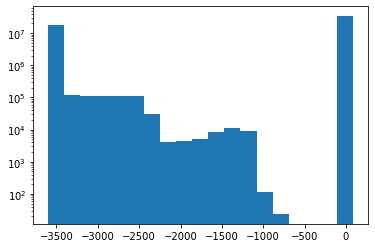

In [35]:
fig, ax = plt.subplots()

bins= np.linspace(np.quantile(pred_delay_list, 0.01), np.quantile(pred_delay_list, 0.99), num=20)
ax.hist(pred_delay_list, bins=bins, log=True)

plt.show()